In [2]:
# TODO: atm the mlflow autolog isnt capturing metrics n params
# and sklearn.autolog throws error( posted the issue on github)
# Ideally, I should be able to fetch most of the imp detail via MLFLOW AUTOLOG. will check that later in time
#============================
# 🧠 MLflow Autologging
# ============================

# mlflow.autolog(log_input_examples=True, log_model_signatures=True)
# mlflow.sklearn.autolog() 
# mlflow.sklearn.autolog(
#     log_input_examples=True,
#     log_model_signatures=True,
#     log_post_training_metrics=True,        # calls model.score() → accuracy
#     disable_for_unsupported_versions=True,  # skips if versions still wonky
#     exclusive=True                          # only patch the sklearn integration
# )

In [3]:

# ============================
# ⚙️ Install Dependencies (if needed )
# ============================
# !pip install mlflow scikit-learn pandas numpy matplotlib seaborn shap requests GitPython
# !pip install --upgrade threadpoolctl
# !pip install setuptools
# !pip install ace_tools 
# !pip install rdflib
# !pip install streamlit-option-menu
# !pip install streamlit-agraph


LIBRARY IMPORTS:

In [4]:
# ============================
# 📦 Standard Library Imports
# ============================
import os
import glob
import io
import json
import time
import ast
import pickle
import platform
import subprocess
from datetime import datetime, timezone
from pprint import pprint
from typing import List, Dict, Any
import xml.etree.ElementTree as ET
import urllib.parse

# ============================
# 📊 Data and Visualization
# ============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# ============================
# 🤖 Machine Learning
# ============================
import sklearn
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# ============================
# 🔬 Experiment Tracking
# ============================
import mlflow
import mlflow.sklearn
from mlflow import MlflowClient

# ============================
# 🌐 Web / API / Networking
# ============================
import requests
from dotenv import load_dotenv

# ============================
# 🧪 Git & Version Control
# ============================
import git
from git import Repo, GitCommandError

# ============================
# 🧠 SHAP for Explainability
# ============================
import shap

# ============================
# 🧬 RDF & Provenance (rdflib)
# ============================
from rdflib import Graph, URIRef, Literal
from rdflib.namespace import PROV, XSD

# ============================
# ⚙️ System Monitoring
# ============================
import psutil


DBREPO INTEGRETION

In [5]:
# API endpoint URL
API_URL = "http://localhost/api/database/c3a42d17-42b7-43c9-a504-2363fb4c9c8d/table/5315e7da-64fb-4fdb-b493-95b4138c765f/data?size=100000&page=0"

# Define the headers
headers = {
    "Accept": "application/json"  # Specify the expected response format
}

try:
    # Send a GET request to the API with the Accept header
    response = requests.get(API_URL, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        dataset = response.json()
        print("API Response:", dataset)
        print( dataset.count)
    else:
        print(f"Error: Received status code {response.status_code}")
        print("Response content:", response.text)
       

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


API Response: [{'id': '1', 'sepallengthcm': '5.100000000000000000', 'sepalwidthcm': '3.500000000000000000', 'petallengthcm': '1.400000000000000000', 'petalwidthcm': '0.200000000000000000', 'species': 'Iris-setosa'}, {'id': '2', 'sepallengthcm': '4.900000000000000000', 'sepalwidthcm': '3.000000000000000000', 'petallengthcm': '1.400000000000000000', 'petalwidthcm': '0.200000000000000000', 'species': 'Iris-setosa'}, {'id': '3', 'sepallengthcm': '4.700000000000000000', 'sepalwidthcm': '3.200000000000000000', 'petallengthcm': '1.300000000000000000', 'petalwidthcm': '0.200000000000000000', 'species': 'Iris-setosa'}, {'id': '4', 'sepallengthcm': '4.600000000000000000', 'sepalwidthcm': '3.100000000000000000', 'petallengthcm': '1.500000000000000000', 'petalwidthcm': '0.200000000000000000', 'species': 'Iris-setosa'}, {'id': '5', 'sepallengthcm': '5.000000000000000000', 'sepalwidthcm': '3.600000000000000000', 'petallengthcm': '1.400000000000000000', 'petalwidthcm': '0.200000000000000000', 'specie

replacing dynamic fetching of data When and if DBREPO isnt running 

In [6]:
# 1. Read the JSON file id the API isnt available this data is saved locally but the data is from the API endpoint
with open("iris_data.json", "r") as f:
    dataset = json.load(f)


Metadata fetching from db repo API CALLS

METADATA ON DATABASE LEVEL

In [7]:

DB_API = "http://localhost/api/database/{db_id}"

def fetch_db_metadata(db_id: str) -> dict:
    url = DB_API.format(db_id=db_id)
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        return resp.json()
    except requests.exceptions.RequestException as e:
        print(f"[⚠️ Error] Failed to fetch DB metadata for {db_id}: {e}")
        return {}  # or return None, depending on what your app prefers


def log_db_metadata(db_meta: dict):
    # 1) Core DB fields as params, defaulting to empty string if key is missing
    mlflow.log_param("database.id",          db_meta.get("id", ""))
    mlflow.log_param("database.name",        db_meta.get("name", ""))
    mlflow.log_param("database.description", db_meta.get("description", ""))

    # 2) Handle nested keys safely for owner
    try:
        owner = db_meta.get("tables", [{}])[0].get("owner", {}).get("username", "")
    except Exception:
        owner = ""
    mlflow.log_param("database.owner", owner)


MATADATA FROM: <ns0:OAI-PMH xmlns:ns0="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/ http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd">

In [8]:
# 1) Fetch your database metadata
db_url = "http://localhost/api/database/c3a42d17-42b7-43c9-a504-2363fb4c9c8d"
db_resp = requests.get(db_url)
db_resp.raise_for_status()
db_data = db_resp.json()

db_id  = db_data["id"]
tbl_id = db_data["tables"][0]["id"]

# 2) Build the OAI-PMH URL, URL-encoding the `set` param
set_param   = f"Databases/{db_id}/Tables/{tbl_id}"
encoded_set = urllib.parse.quote(set_param, safe="")

oai_url = (
    "http://localhost/api/oai"
    f"?metadataPrefix=oai_dc"
    f"&from=2025-03-01"
    f"&until=2025-03-07"
    f"&set={encoded_set}"
    f"&resumptionToken=string"
    f"&fromDate=2025-03-07T19%3A35%3A51.476Z"
    f"&untilDate=2025-03-07T19%3A35%3A51.476Z"
    f"&parametersString=string"
)

# 3) Call and parse
try:
    resp = requests.get(oai_url)
    resp.raise_for_status()

    if "xml" in resp.headers.get("Content-Type", ""):
        root = ET.fromstring(resp.text)
        print(ET.tostring(root, encoding="utf-8").decode())
    else:
        print("Non-XML response:", resp.headers.get("Content-Type"), resp.text)

except requests.exceptions.RequestException as e:
    print("Request failed:", e)


<ns0:OAI-PMH xmlns:ns0="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/ http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd">
    <ns0:responseDate>2025-04-25T11:13:30Z</ns0:responseDate>
    <ns0:request verb="Identify">https://localhost/api/oai</ns0:request>
    <ns0:Identify>
    <ns0:repositoryName>Database Repository</ns0:repositoryName>
    <ns0:baseURL>http://localhost</ns0:baseURL>
    <ns0:protocolVersion>2.0</ns0:protocolVersion>
    <ns0:adminEmail>noreply@localhost</ns0:adminEmail>
    <ns0:earliestDatestamp />
    <ns0:deletedRecord>persistent</ns0:deletedRecord>
    <ns0:granularity>YYYY-MM-DDThh:mm:ssZ</ns0:granularity>
</ns0:Identify>
</ns0:OAI-PMH>


In [9]:
# …after you fetch & parse your XML into `root`…
ns = {"oai": "http://www.openarchives.org/OAI/2.0/"}

repo_name   = root.findtext("oai:Identify/oai:repositoryName", namespaces=ns) or "N/A"
base_url    = root.findtext("oai:Identify/oai:baseURL", namespaces=ns) or "N/A"
protocol    = root.findtext("oai:Identify/oai:protocolVersion", namespaces=ns) or "N/A"
admin_email = root.findtext("oai:Identify/oai:adminEmail", namespaces=ns) or "N/A"
gran        = root.findtext("oai:Identify/oai:granularity", namespaces=ns) or "N/A"


METADATA ON History Logging

In [10]:
url = "http://localhost/api/database/c3a42d17-42b7-43c9-a504-2363fb4c9c8d/table/5315e7da-64fb-4fdb-b493-95b4138c765f/history"

try:
    # Send a GET request to the API
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        print("API Response:", data)
    else:
        print(f"Error: Received status code {response.status_code}")
        print("Response content:", response.text)

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

API Response: [{'timestamp': '2025-04-23T20:42:29.501Z', 'event': 'insert', 'total': 150}]


In [11]:
first   = data[0]
last    = data[-1]
count_0 = first["total"]    # e.g. 149
count_N = last["total"]     # e.g. 149 again, or changed
ts_last = last["timestamp"]  # e.g. "2025-03-28T17:42:38.058Z"
n_insert = sum(1 for ev in data if ev["event"]=="insert")
n_delete = sum(1 for ev in data if ev["event"]=="delete")
history = response.json()
first, last = history[0], history[-1]

# summary stats
count_start = first["total"]
count_end   = last["total"]
ts_last     = last["timestamp"]
n_insert    = sum(1 for ev in history if ev["event"]=="insert")
n_delete    = sum(1 for ev in history if ev["event"]=="delete")

Dataset metadata fetching from ZONEDO or any public dataset repositories to gain more details

In [12]:

def fetch_and_log_dataset_metadata_nested(doi_url: str):
    # 1) fetch the CSL+JSON
    headers = {"Accept": "application/vnd.citationstyles.csl+json"}
    r = requests.get(doi_url, headers=headers); r.raise_for_status()
    meta = r.json()

    # 2) pull out what you care about
    authors = [f"{a.get('family','')} {a.get('given','')}".strip()
               for a in meta.get("author", [])]
    pubdate = "-".join(str(x) for x in meta.get("issued",{}).get("date-parts",[[]])[0])

    # 3) assemble one nested dict
    public_datasetRepository_metadata = {
      "zenodo": {
        "title":     meta.get("title"),
        "doi":       meta.get("DOI"),
        "authors":   authors,
        "published": pubdate,
        "publisher": meta.get("publisher"),
      },
   
    }

      # 4) log it as a single JSON artifact
    mlflow.log_dict(public_datasetRepository_metadata,
                "public_datasetRepository_metadata.json")

    # 2) Flatten and log the important bits as params:
    z = public_datasetRepository_metadata["zenodo"]
    
    mlflow.log_param("dataset.title",     z["title"])
    mlflow.log_param("dataset.doi",       z["doi"])
    mlflow.log_param("dataset.authors",   json.dumps(z["authors"]))
    mlflow.log_param("dataset.published", z["published"])
    mlflow.log_param("dataset.publisher", z["publisher"])
    
   

##################################################################
# DATA PREPROCESSING STEPS
###################################################################

STEP 1: LOAD DATASET

In [13]:
# ── 2) Load into a DataFrame ─────────────────────────────────────────────────
df = pd.DataFrame(dataset)

STEP2: seperate Dependent and Independent variables and drop unnecessary columns like ID

In [14]:
target_col = df.columns[-1]      # e.g. "species"

# 2) extract y as the Series of labels
y = df[target_col]               # length == n_samples

# 3) build X by dropping just that one column
X = df.drop(columns=[target_col])

# 4) drop any ID column (case-insensitive)
id_cols = [c for c in X.columns if c.lower() == "id"]
if id_cols:
    X = X.drop(columns=id_cols)

# 5) coerce numeric where possible
for c in X.columns:
    try:
        X[c] = pd.to_numeric(X[c])
    except Exception:
        pass

print("Shapes:", X.shape, y.shape)


Shapes: (150, 4) (150,)


STEP3: Label Encoding as the target values are class names

In [15]:

le = LabelEncoder()
y = le.fit_transform(y)  

# now y_enc is a 1d numpy array of ints 0,1,2
print("Classes:", le.classes_)  
y

Classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
# ── 4) Cast feature columns to numeric where possible ─────────────────────────
for col in X.columns:
    try:
        X[col] = pd.to_numeric(X[col])   # no errors="ignore"
    except ValueError:
        # if it can’t be cast, just leave it as-is
        pass


In [17]:
# ── 5) Drop any “id” column (case-insensitive) ────────────────────────────────
dropped = [c for c in X.columns if c.lower() == "id"]
X = X.drop(columns=dropped, errors="ignore")

# ============================
# 📂 Setup MLflow
# ============================

In [30]:

project_dir = os.getcwd()
mlflow.set_tracking_uri("mlrunlogs/mlflow.db")
mlflow.set_experiment("RandomForest-Iris-CSV")
mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=True)


# ============================
# 🔄 Git Commit Hash for previous commit for metadata
# ============================

In [19]:

repo_dir = "C:/Users/reema/REPO"
previous_commit_repo = git.Repo(repo_dir)
previous_commit_hash = previous_commit_repo.head.object.hexsha

# ============================
# Make threadpoolctl safe so MLflow’s autologger won’t crash ───
# ============================

In [20]:
try:
    import threadpoolctl
    _orig = threadpoolctl.threadpool_info
    def _safe_threadpool_info(*args, **kwargs):
        try:
            return _orig(*args, **kwargs)
        except Exception:
            return []
    threadpoolctl.threadpool_info = _safe_threadpool_info
except ImportError:
    pass  # if threadpoolctl isn’t installed, autolog will skip unsupported versions

# ─── 1) Enable generic autolog (will auto-patch sklearn under the hood) ───
import mlflow
mlflow.autolog(
    log_input_examples=True,
    log_model_signatures=True
)

2025/04/25 13:13:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


# ============================
# 🚀 Start MLflow Run 
# ============================


📝 Justification for `n_estimators` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `criterion` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `max_depth` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `min_samples_split` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `min_samples_leaf` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `max_features` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `bootstrap` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `oob_score` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `class_weight` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `random_state` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `verbose` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `n_jobs` (Hyperparameter configuration)


→ Why did you choose this value?  test



📝 Justification for `model_choice`


→ Why did you choose RandomForestClassifier for this task?  test



📝 Justification for `target_variable`


→ Why did you choose this column as the prediction target?  test



📝 Justification for `test_split`


→ Why this train/test ratio (e.g., 80/20)?  test



📝 Justification for `metric_choice`


→ Why accuracy/f1/ROC-AUC as your evaluation metric?  test



📝 Justification for `threshold_accuracy`


→ Why 0.95 as performance threshold?  test



📝 Justification for `dataset_version`


→ Why use this specific dataset version?  test



📝 Justification for `drop_column_X`


→ Why drop any specific columns from the dataset?  test



📝 Justification for `experiment_name`


→ Any context behind this experiment name or setup?  test


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Do

✅ Commit successful.
🚀 Push successful.


<Figure size 600x600 with 0 Axes>

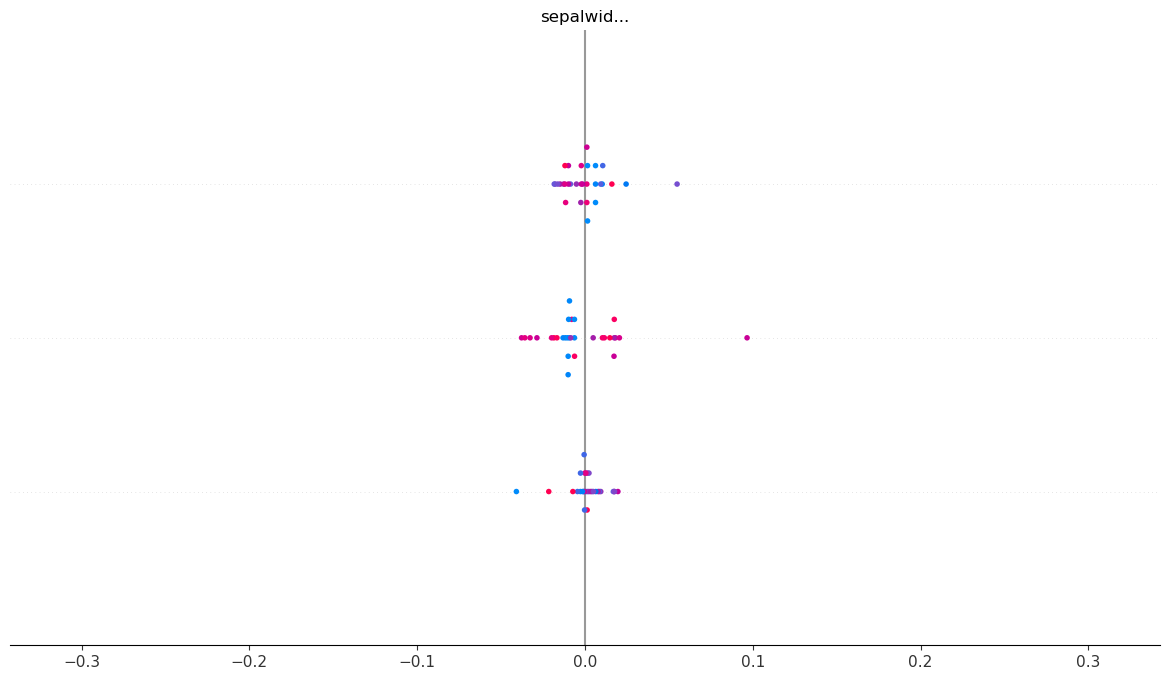

In [21]:

with mlflow.start_run() as run:
    #################################################
# Justification LOGGER
################################################

    def log_with_justification(log_func, key, value, context=""):
        """
        Log a parameter/metric/tag using `log_func` and ask for justification via console.
        """
        log_func(key, value)
        print(f"\n📝 Justification for `{key}` ({context})")
        user_reason = input("→ Why did you choose this value? ")
        mlflow.set_tag(f"justification_{key}", user_reason or "No justification provided")

    def log_justification(key: str, question: str):
        print(f"\n📝 Justification for `{key}`")
        user_reason = input(f"→ {question} ")
        mlflow.set_tag(f"justification_{key}", user_reason or "No justification provided")



    meta = fetch_and_log_dataset_metadata_nested(
            "https://doi.org/10.5281/zenodo.1404173",
           
        )

    #Datasbase info logging
    db_id = "c3a42d17-42b7-43c9-a504-2363fb4c9c8d"
    db_meta = fetch_db_metadata(db_id)
    log_db_metadata(db_meta)

    #OAI metadata logging from api endpoint
    # log as tags
    mlflow.set_tag("dbrepo.repository_name", repo_name)
    mlflow.set_tag("dbrepo.base_url",       base_url)
    mlflow.set_tag("dbrepo.protocol_version", protocol)
    mlflow.set_tag("dbrepo.admin_email",     admin_email)
    mlflow.set_tag("dbrepo.granularity",     gran)

    #From history API logging
    # provenance tags
    mlflow.set_tag("dbrepo.table_last_modified", ts_last)

    # row-count metrics
    mlflow.log_metric("dbrepo.row_count_start", count_start)
    mlflow.log_metric("dbrepo.row_count_end",   count_end)

    # change-event metrics
    mlflow.log_metric("dbrepo.num_inserts", n_insert)
    mlflow.log_metric("dbrepo.num_deletes", n_delete)
    
    # 2) Capture raw metadata
    mlflow.set_tag("data_source", API_URL)
    mlflow.log_param("retrieval_time", datetime.utcnow().isoformat())
    mlflow.log_param("n_records", len(df))
    mlflow.log_param("columns_raw", df.columns.tolist())
    mlflow.log_param("dropped_columns", id_cols)

    # 4) Post‐processing metadata
    mlflow.log_param("n_features_final", X.shape[1])
    mlflow.log_param("feature_names", X.columns.tolist())
    mlflow.set_tag("target_name", y)

       # Label encoding
    label_map = {int(idx): cls for idx, cls in enumerate(le.classes_)}
    
    # Save to an in-memory file
    buffer = io.StringIO()
    json.dump(label_map, buffer, indent=2)
    buffer.seek(0)
    
    # Log it to MLflow
    mlflow.log_text(buffer.getvalue(), artifact_file="label_mapping.json")
   
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"RandomForest_Iris_v{ts}"
    mlflow.set_tag("model_name",model_name)
    
    train_start_ts = datetime.now().isoformat()
    mlflow.set_tag("training_start_time", train_start_ts)

    test_size    = 0.2
    random_state = 42
    
    # 📈 Model Training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # ── 2) Log dataset split params ──
    mlflow.log_param("test_size", test_size)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_train_samples", X_train.shape[0])
    mlflow.log_param("n_test_samples",  X_test.shape[0])
    mlflow.log_param("n_features",      X_train.shape[1])

     # 1) Define a more complex hyperparameter dict
    hyperparams = {
        "n_estimators":       200,
        "criterion":          "entropy",
        "max_depth":          12,
        "min_samples_split":  5,
        "min_samples_leaf":   2,
        "max_features":       "sqrt",
        "bootstrap":          True,
        "oob_score":          False,
        "class_weight":       None,
        "random_state":       42,
        "verbose":            1,
        "n_jobs":             -1
    }
    
    # 2) Log them ALL at once
    # mlflow.log_params(hyperparams) #TEST
    model = RandomForestClassifier(**hyperparams)

    for key, val in hyperparams.items():
        log_with_justification(mlflow.log_param, key, val, context="Hyperparameter configuration")

    # Prompt for and log justifications for high-level modeling decisions
    log_justification("model_choice", "Why did you choose RandomForestClassifier for this task?")
    log_justification("target_variable", "Why did you choose this column as the prediction target?")
    log_justification("test_split", "Why this train/test ratio (e.g., 80/20)?")
    log_justification("metric_choice", "Why accuracy/f1/ROC-AUC as your evaluation metric?")
    log_justification("threshold_accuracy", "Why 0.95 as performance threshold?")
    log_justification("dataset_version", "Why use this specific dataset version?")
    log_justification("drop_column_X", "Why drop any specific columns from the dataset?")
    log_justification("experiment_name", "Any context behind this experiment name or setup?")



    
    model.fit(X_train, y_train)

    train_end_ts = datetime.now().isoformat()
    mlflow.set_tag("training_end_time", train_end_ts)

     # ── 6) Predict & log metrics ──
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    prec = precision_score(y_test, y_pred, average="macro")
    rec  = recall_score(y_test,    y_pred, average="macro")
    f1   = f1_score(y_test,      y_pred, average="macro")
    
    # mlflow.log_metric("precision_macro", prec) #TEST
    # mlflow.log_metric("recall_macro",    rec)#TEST
    # mlflow.log_metric("f1_macro",        f1)#TEST
    # mlflow.log_metric("accuracy", acc)#TEST
    # mlflow.log_metric("roc_auc",   auc)#TEST

    # ✅ Log Environment Automatically
    # mlflow.log_params({
    #     "python_version": platform.python_version(),
    #     "os_platform": f"{platform.system()} {platform.release()}",
    #     "sklearn_version": sklearn.__version__,
    #     "pandas_version": pd.__version__,
    #     "numpy_version": np.__version__,
    #     "matplotlib_version": matplotlib.__version__,
    #     "seaborn_version": sns.__version__,
    #     "shap_version": shap.__version__,
    # })#TEST

    # ✅ Git and Notebook Metadata
    mlflow.set_tag("notebook_name", "RQ1.ipynb")

    # ✅ Dataset Metadata Tags
    mlflow.set_tag("dataset_name", "Iris") #TODO
    mlflow.set_tag("dataset_version", "1.0.0") #TODO
    mlflow.set_tag("dataset_id", "iris_local") #TODO


    # ─── 2) Create a folder for this run’s plots ───
    plot_dir = os.path.join("plots", model_name)
    os.makedirs(plot_dir, exist_ok=True)

    # 1) Feature Importance Bar Chart
    importances = model.feature_importances_
    try:
        feature_names = X_train.columns
    except AttributeError:
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    fi_path = os.path.join(plot_dir, "feature_importances.png")

    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances, y=feature_names)
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(fi_path)
    mlflow.log_artifact(fi_path)
    plt.close()


# 2) Multi-class ROC Curves
# Binarize labels for one-vs-rest
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    for idx, cls in enumerate(classes):
        disp = RocCurveDisplay.from_predictions(
            y_test_bin[:, idx], 
            y_proba[:, idx],
            name=f"ROC for class {cls}"
        )
        roc_path = os.path.join(plot_dir, f"roc_curve_cls_{cls}.png")
        disp.figure_.savefig(roc_path)
        mlflow.log_artifact(roc_path)
        plt.close(disp.figure_)


    # 3) Multi-class Precision-Recall Curves
    for idx, cls in enumerate(classes):
        disp = PrecisionRecallDisplay.from_predictions(
            y_test_bin[:, idx], 
            y_proba[:, idx],
            name=f"PR curve for class {cls}"
        )
        pr_path = os.path.join(plot_dir, f"pr_curve_cls_{cls}.png")
        disp.figure_.savefig(pr_path)
        mlflow.log_artifact(pr_path)
        plt.close(disp.figure_)
        
    # ✅ Confusion Matrix Plot
    cm_path = os.path.join(plot_dir, "confusion_matrix.png")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)

    # ✅ SHAP Summary
    shap_path = os.path.join(plot_dir, "shap_summary.png")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig(shap_path)
    mlflow.log_artifact(shap_path)


    
    # ─── 1) Build a .pkl filename (you can include your model_name for clarity)
    pkl_path = f"Trained_models/{model_name}.pkl"
    
    # ─── 2) Serialize your trained model to disk
    with open(pkl_path, "wb") as f:
        pickle.dump(model, f)
    
    # ─── 3) Log that pickle file as an MLflow artifact
    #     It will appear under Artifacts → models/RandomForest_Iris_vYYYYMMDD_HHMMSS.pkl
    mlflow.log_artifact(pkl_path, artifact_path=model_name)
        
    def get_latest_commit_hash(repo_path="."):
        # returns the full SHA of HEAD
        res = subprocess.run(
            ["git", "-C", repo_path, "rev-parse", "HEAD"],
            capture_output=True, text=True, check=True)
        
        return res.stdout.strip()

    def get_remote_url(repo_path=".", remote="origin"):
        # returns something like git@github.com:user/repo.git or https://...
        res = subprocess.run(
            ["git", "-C", repo_path, "config", "--get", f"remote.{remote}.url"],
            capture_output=True, text=True, check=True
        )
        return res.stdout.strip()
    
    def make_commit_link(remote_url, commit_hash):
        # handle GitHub/GitLab convention; strip “.git” if present
        base = remote_url.rstrip(".git")
        # if SSH form (git@github.com:owner/repo), convert to https
        if base.startswith("git@"):
            base = base.replace(":", "/").replace("git@", "https://")
        return f"{base}/commit/{commit_hash}"

    
    def simple_commit_and_push_and_log(repo_path=".", message="Auto commit", remote="origin", branch="main"):
    # 1) Check for changes
        status = subprocess.run(
            ["git", "-C", repo_path, "status", "--porcelain"],
            capture_output=True, text=True
        )
        if not status.stdout.strip():
            print("🟡 No changes to commit.")
            return None, None
    
        # 2) Stage everything
        add = subprocess.run(
            ["git", "-C", repo_path, "add", "--all"],
            capture_output=True, text=True
        )
        if add.returncode:
            print("❌ git add failed:\n", add.stderr)
            return None, None
    
        # 3) Commit
        commit = subprocess.run(
            ["git", "-C", repo_path, "commit", "-m", message],
            capture_output=True, text=True
        )
        if commit.returncode:
            print("❌ git commit failed:\n", commit.stderr)
            return None, None
        print("✅ Commit successful.")
    
        # 4) Push
        push = subprocess.run(
            ["git", "-C", repo_path, "push", "-u", remote, branch],
            capture_output=True, text=True
        )
        if push.returncode:
            print("❌ git push failed:\n", push.stderr)
        else:
            print("🚀 Push successful.")
    
        # 5) Retrieve hash & remote URL
        sha = get_latest_commit_hash(repo_path)
        url = get_remote_url(repo_path, remote)
        link = make_commit_link(url, sha)
    
        return sha, link
    
      
    sha, link = simple_commit_and_push_and_log(
        repo_path=".",
        message="Auto commit after successful training"
    )
    if sha and link:
        diff_text = subprocess.check_output(
            ["git", "-C", ".", "diff", previous_commit_hash, sha],
            encoding="utf-8",
            errors="ignore"    # or "replace"
        )
                
        # 1) Get your repo’s remote URL and normalize to HTTPS
        remote_url = subprocess.check_output(
            ["git", "config", "--get", "remote.origin.url"],
            text=True
        ).strip().rstrip(".git")
        if remote_url.startswith("git@"):
            # git@github.com:owner/repo.git → https://github.com/owner/repo
            remote_url = remote_url.replace(":", "/").replace("git@", "https://")
        
        # 2) Build commit URLs
        previous_commit_url  = f"{remote_url}/commit/{previous_commit_hash}"
        current_commit_url = f"{remote_url}/commit/{sha}"
        diff_data = {
            "previous_commit":  previous_commit_hash,
            "previous_commit_url":previous_commit_url,
            "current_commit_url":current_commit_url,
            "current_commit": sha,
            "diff": diff_text
        }
        mlflow.log_dict(
            diff_data,
            artifact_file="commit_diff.json"
        )
        mlflow.set_tag("git_previous_commit_hash", previous_commit_hash)
        mlflow.set_tag("git_current_commit_hash", sha)
        mlflow.set_tag("git__current_commit_url", link) 


    client   = MlflowClient()
    run_id    = run.info.run_id
    run_info  = client.get_run(run_id).info
    run_data  = client.get_run(run_id).data
    
    # 1) params, metrics, tags
    params  = dict(run_data.params)
    metrics = dict(run_data.metrics)
    tags    = dict(run_data.tags)

    # (4) List artifacts under a specific subfolder
    run_meta     = client.get_run(run_id).info
    artifact_uri = run_meta.artifact_uri  # base URI for all artifacts
    
    artifact_meta = []
    
    def _gather(path=""):
        for af in client.list_artifacts(run_id, path):
            # If it’s a directory, recurse
            if af.is_dir:
                _gather(af.path)
                continue
    
            rel_path = af.path
            uri      = f"{artifact_uri}/{rel_path}"
            lower    = rel_path.lower()
    
            # 1) Text files → download & embed contents
            if lower.endswith((".json", ".txt", ".patch")):
                local = client.download_artifacts(run_id, rel_path)
                with open(local, "r", encoding="utf-8") as f:
                    content = f.read()
                artifact_meta.append({
                    "path":    rel_path,
                    "type":    "text",
                    "content": content
                })
    
            # 2) Images → surface a clickable URI
            elif lower.endswith((".png", ".jpg", ".jpeg", ".svg")):
                artifact_meta.append({
                    "path": rel_path,
                    "type": "image",
                    "uri":  uri
                })
    
            # 3) Everything else → just link
            else:
                artifact_meta.append({
                    "path": rel_path,
                    "type": "other",
                    "uri":  uri
                })
    
    # Run the gather
    _gather()
     
    summary = {
        "run_id":         run_id,
        "run_name": run_info.run_name,
        "experiment_id":  run_info.experiment_id,
        "start_time":     run_info.start_time,
        "end_time":       run_info.end_time,
        "params":         params,
        "metrics":        metrics,
        "tags":           tags,
        "artifacts":      artifact_meta
    }
    

    # 1) Determine notebook directory (where your .ipynb lives)
    notebook_dir = os.getcwd()
    
    # ✅ Create a subdirectory inside MODEL_PROVENANCE for the model
    summary_dir = os.path.join(os.getcwd(), "MODEL_PROVENANCE", model_name)
    os.makedirs(summary_dir, exist_ok=True)
    
   # 2) Pick a filename based on your model_name
    summary_filename   = f"{model_name}_run_summary.json"
    summary_local_path = os.path.join(summary_dir, summary_filename)
   # 3) Write the JSON locally
    with open(summary_local_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)
    
    # 4) (Optional) Mirror it into MLflow artifacts under a single folder
    mlflow.log_artifact(summary_local_path, artifact_path="run_summaries")

    mlflow.end_run()

what does it create: 
lable_mapping in the current dir
provenence file :REPO/notebooks/RQ_notebooks/MODEL_PROVENANCE/RandomForest_Iris_v20250425_120045_run_summary.json
plots based on run:REPO/notebooks/RQ_notebooks/plots/RandomForest_Iris_v20250425_120045/shap_summary.png
mlrun:REPO/notebooks/RQ_notebooks/mlrunlogs/mlflow.db/615223710259862608/5d1fa0fc65af47128f3200628b1afaea
trained model:REPO/notebooks/RQ_notebooks/Trained_models/RandomForest_Iris_v20250425_120852.pkl

1. Standards-compliant export (JSON-LD + Turtle)
I already have your plain run_summary.json , wrap it in a JSON-LD context that maps your fields into PROV-O terms, then use rdflib to emit Turtle:

In [ ]:
import json
import pandas as pd

# Load the JSON file
json_path = "/mnt/data/REPO/notebooks/RQ_notebooks/MODEL_PROVENANCE/RandomForest_Iris_v20250425_125653/RandomForest_Iris_v20250425_125653_run_summary.json"
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract justification tags
justifications = {
    k: v for k, v in data.get("tags", {}).items()
    if k.startswith("justification_")
}

# Create a DataFrame
justification_df = pd.DataFrame([
    {"Decision": k.replace("justification_", ""), "Justification": v}
    for k, v in justifications.items()
])

import ace_tools as tools; tools.display_dataframe_to_user(name="Researcher Justifications", dataframe=justification_df)


In [66]:

def iso8601(ms):
    """Convert milliseconds since epoch to ISO8601 UTC."""
    return datetime.fromtimestamp(ms / 1000, tz=timezone.utc).isoformat()

for json_path in glob.glob("MODEL_PROVENANCE/*/*_run_summary.json"):
    basename   = os.path.basename(json_path)
    model_name = basename.rsplit("_run_summary.json", 1)[0]

    with open(json_path, "r", encoding="utf-8") as f:
        summary = json.load(f)

    #–– Minimal override context: keep all your flat fields as-is,
    #–– and only map the actual PROV terms to their IRIs.
    ctx = {
        # keep these flat
        "run_id":       { "@id": "run_id" },
        "run_name":     { "@id": "run_name" },
        "experiment_id":{ "@id": "experiment_id" },
        "params":       { "@id": "params" },
        "metrics":      { "@id": "metrics" },
        "artifacts":    { "@id": "artifacts" },
        "tags":         { "@id": "tags" },

        # provenance namespace
        "prov": "http://www.w3.org/ns/prov#",
        "xsd":  "http://www.w3.org/2001/XMLSchema#",

        # map your timestamp fields into PROV
        "start_time": { "@id": "prov:startedAtTime", "@type": "xsd:dateTime" },
        "end_time":   { "@id": "prov:endedAtTime",   "@type": "xsd:dateTime" },

        # PROV-used/generated
        "used":      { "@id": "prov:used",      "@type": "@id" },
        "generated": { "@id": "prov:generated", "@type": "@id" },

        # JSON-LD boilerplate
        "@id":   "@id",
        "@type": "@type"
    }

    #–– Build JSON-LD document, re-using your original keys verbatim
    doc = {
        "@context":      ctx,
        "run_id":        summary["run_id"],
        "run_name":      summary.get("run_name"),
        "experiment_id": summary.get("experiment_id"),
        "params":        summary.get("params", {}),
        "metrics":       summary.get("metrics", {}),
        "artifacts":     summary.get("artifacts", []),
        "tags":          summary.get("tags", {}),

        # PROV fields:
        "start_time": iso8601(summary["start_time"])
    }

    if summary.get("end_time") is not None:
        doc["end_time"] = iso8601(summary["end_time"])

    # for used/generated, just point at your dataset/model URIs
    # (or blank-node them if you prefer richer structure)
    doc["used"] = summary.get("tags", {}).get("dataset_uri") or []
    doc["generated"] = [
        art.get("uri") or art.get("path")
        for art in summary.get("artifacts", [])
    ]

    #–– write JSON-LD
    out_jsonld = os.path.join("MODEL_PROVENANCE", model_name, f"{model_name}.jsonld")
    with open(out_jsonld, "w", encoding="utf-8") as f:
        json.dump(doc, f, indent=2)

    #–– parse & serialize to Turtle
    g = Graph().parse(data=json.dumps(doc), format="json-ld")
    out_ttl = os.path.join("MODEL_PROVENANCE", model_name, f"{model_name}.ttl")
    g.serialize(destination=out_ttl, format="turtle")

    print(f"Converted {basename} → {os.path.basename(out_jsonld)}, {os.path.basename(out_ttl)}")



Converted RandomForest_Iris_v20250425_121328_run_summary.json → RandomForest_Iris_v20250425_121328.jsonld, RandomForest_Iris_v20250425_121328.ttl


This code programatically, finds diff between generated Json file and created JsonLD and .TTL file to make it easier to understand if there is any discrepency

In [67]:


def load_as_dict(path):
    if path.endswith((".ttl", ".turtle")):
        g = Graph()
        g.parse(path, format="turtle")
        # normalize to JSON-LD dict
        return json.loads(g.serialize(format="json-ld", indent=2))
    else:
        with open(path, encoding="utf-8") as f:
            return json.load(f)

def compare_json(a, b, path=""):
    diffs = []
    if isinstance(a, dict) and isinstance(b, dict):
        all_keys = set(a) | set(b)
        for k in all_keys:
            new_path = f"{path}/{k}" if path else k
            if k not in a:
                diffs.append({"path": new_path, "type": "added",   "a": None,    "b": b[k]})
            elif k not in b:
                diffs.append({"path": new_path, "type": "removed", "a": a[k],   "b": None})
            else:
                diffs.extend(compare_json(a[k], b[k], new_path))
    elif isinstance(a, list) and isinstance(b, list):
        for i, (ia, ib) in enumerate(zip(a, b)):
            diffs.extend(compare_json(ia, ib, f"{path}[{i}]"))
        # handle length mismatches
        if len(a) < len(b):
            for i in range(len(a), len(b)):
                diffs.append({"path": f"{path}[{i}]", "type": "added",   "a": None,  "b": b[i]})
        elif len(a) > len(b):
            for i in range(len(b), len(a)):
                diffs.append({"path": f"{path}[{i}]", "type": "removed", "a": a[i],  "b": None})
    else:
        if a != b:
            diffs.append({"path": path, "type": "changed", "a": a, "b": b})
    return diffs

# --- Usage example -----------------------------------------------
# REPO/notebooks/RQ_notebooks/MODEL_PROVENANCE/RandomForest_Iris_v20250425_121328/RandomForest_Iris_v20250425_121328_run_summary.json
# # Compare JSON-LD vs Turtle:
# a = load_as_dict("MODEL_PROVENANCE/RandomForest_Iris_v20250423_230422_run_summary.json")
# b = load_as_dict("MODEL_PROVENANCE/RandomForest_Iris_v20250423_230422.ttl")
# diffs_jsonld_vs_ttl = compare_json(a, b)

# # Compare JSON vs JSON-LD:
# c = load_as_dict("MODEL_PROVENANCE/RandomForest_Iris_v20250423_230422_run_summary.json")
# d = load_as_dict("MODEL_PROVENANCE/RandomForest_Iris_v20250423_230422.jsonld")
# diffs_json_vs_jsonld = compare_json(c, d)

# Define base directory
base_dir = os.path.join("MODEL_PROVENANCE", model_name)

# Build full paths for the files to compare
summary_json    = os.path.join(base_dir, f"{model_name}_run_summary.json")
turtle_file     = os.path.join(base_dir, f"{model_name}.ttl")
jsonld_file     = os.path.join(base_dir, f"{model_name}.jsonld")

# Load files
a = load_as_dict(summary_json)
b = load_as_dict(turtle_file)
c = load_as_dict(summary_json)
d = load_as_dict(jsonld_file)

# Perform comparisons
diffs_jsonld_vs_ttl = compare_json(a, b)
diffs_json_vs_jsonld = compare_json(c, d)

# Build DataFrames for interactive inspection
df1 = pd.DataFrame(diffs_jsonld_vs_ttl)
df2 = pd.DataFrame(diffs_json_vs_jsonld)

# --- Summaries & Filtering ---------------------------------------

def summarize_and_preview(df, preview_n=10):
    print("Change summary:")
    print(df['type'].value_counts().to_string(), "\n")
    
    print(f"First {preview_n} ‘changed’ entries:")
    # print(df[df['type']=="changed"].head(preview_n).to_string(index=False), "\n")
    
    # Top‐level (one slash) adds/removes
    top = df[df['path'].str.count("/") == 1]
    print("Top-level adds/removes:")
    print(top[top['type'].isin(['added','removed'])].to_string(index=False))

print("== JSON-LD vs TTL ==")
summarize_and_preview(df1)

print("\n== JSON vs JSON-LD ==")
summarize_and_preview(df2)



== JSON-LD vs TTL ==
Change summary:
type
changed    1 

First 10 ‘changed’ entries:
Top-level adds/removes:
Empty DataFrame
Columns: [path, type, a, b]
Index: []

== JSON vs JSON-LD ==
Change summary:
type
added      3
removed    1
changed    1 

First 10 ‘changed’ entries:
Top-level adds/removes:
Empty DataFrame
Columns: [path, type, a, b]
Index: []


In [68]:
# show all the removed paths (in JSON but not in JSON-LD)
print("Removed in JSON-LD comparison:")
print(df2[df2['type']=="removed"][['path']].to_string(index=False))

# show all the added paths (in JSON-LD but not in JSON)
print("\nAdded in JSON-LD comparison:")
print(df2[df2['type']=="added"][['path']].to_string(index=False))

Removed in JSON-LD comparison:
    path
end_time

Added in JSON-LD comparison:
     path
 @context
     used
generated


In [69]:
# show all the removed paths (in JSON but not in JSON-LD)
print("Removed in .ttl comparison:")
print(df1[df1['type']=="removed"][['path']].to_string(index=False))

# show all the added paths (in JSON-LD but not in JSON)
print("\nAdded in .ttl comparison:")
print(df1[df1['type']=="added"][['path']].to_string(index=False))

Removed in .ttl comparison:
Empty DataFrame
Columns: [path]
Index: []

Added in .ttl comparison:
Empty DataFrame
Columns: [path]
Index: []


Checks for completeness and mapping and time taken, needs work #TODO

In [70]:

# ── User configuration ─────────────────────────────────────────────────────────

# Which keys must appear in every run_summary.json?
REQUIRED_TOPLEVEL = {
    "run_id", "start_time", "end_time",
    "params", "metrics", "tags", "artifacts"
}

# A couple of sub-fields we also want to spot-check:
REQUIRED_PARAMS  = {"random_state"}
REQUIRED_METRICS = {"accuracy"}

JSON_SUMMARIES = glob.glob("MODEL_PROVENANCE/*_run_summary.json")


# ── Helpers ────────────────────────────────────────────────────────────────────

def iso8601(ms):
    return datetime.fromtimestamp(ms/1000, tz=timezone.utc).isoformat()


def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def write_json(path, obj):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)


def convert_to_jsonld_and_ttl(summary, basename):
    # build @context
    ctx = {
        "prov":    "http://www.w3.org/ns/prov#",
        "xsd":     "http://www.w3.org/2001/XMLSchema#",
        "run":     "prov:Activity",
        "start":   "prov:startedAtTime",
        "end":     "prov:endedAtTime",
        "used":    "prov:used",
        "gen":     "prov:generated",
        "param":   "prov:hadParameter",
        "metric":  "prov:hadQuality",
        "entity":  "prov:Entity",
        "label":   "prov:label",
        "value":   "prov:value",
        "version": "prov:hadRevision",
        "id":      "@id",
        "type":    "@type"
    }

    jsonld = {
        "@context": ctx,
        "@id":      f"urn:run:{summary['run_id']}",
        "@type":    "run",
        "start": {
            "@type":  "xsd:dateTime",
            "@value": iso8601(summary["start_time"])
        }
    }
    if summary.get("end_time") is not None:
        jsonld["end"] = {
            "@type":  "xsd:dateTime",
            "@value": iso8601(summary["end_time"])
        }

    # params
    jsonld["param"] = [
        {"@type":"entity","label":k,"value":str(v)}
        for k,v in summary.get("params",{}).items()
    ]
    # metrics
    jsonld["metric"] = [
        {"@type":"entity","label":k,
         "value":{"@type":"xsd:decimal","@value":v}}
        for k,v in summary.get("metrics",{}).items()
    ]
    # artifacts
    jsonld["gen"] = [
        {
            "@type":"entity",
            "label": art.get("path") or art.get("label"),
            "prov:location": (
                art.get("uri")
                or (art.get("content","")[:30]+"…")
                if isinstance(art.get("content"),str)
                else ""
            )
        }
        for art in summary.get("artifacts",[])
    ]
    # dataset used
    jsonld["used"] = {
        "@type":"entity",
        "label": summary["tags"].get("dataset_name"),
        "version": summary["tags"].get("dataset_version")
    }

    # write JSON-LD
    out_jsonld = f"MODEL_PROVENANCE/{basename}.jsonld"
    write_json(out_jsonld, jsonld)

    # serialize TTL
    g = Graph().parse(data=json.dumps(jsonld), format="json-ld")
    out_ttl = f"MODEL_PROVENANCE/{basename}.ttl"
    g.serialize(destination=out_ttl, format="turtle")

    return out_jsonld, out_ttl


def normalize_jsonld(js):
    """Simple deep-sort so compare_json doesn’t trip over ordering."""
    if isinstance(js, dict):
        return {k: normalize_jsonld(js[k]) for k in sorted(js)}
    if isinstance(js, list):
        return sorted((normalize_jsonld(el) for el in js),
                      key=lambda x: json.dumps(x, sort_keys=True))
    return js


def diff_roundtrip(orig_json, jsonld_path, ttl_path):
    orig = load_json(orig_json)
    ld   = load_json(jsonld_path)

    # parse TTL back to JSON-LD
    g = Graph().parse(ttl_path, format="turtle")
    ttl_as_ld = json.loads(g.serialize(format="json-ld"))

    # normalize
    nl = normalize_jsonld(ld)
    nt = normalize_jsonld(ttl_as_ld)

    return {
        "orig_vs_jsonld":   compare_json(orig, ld),
        "jsonld_vs_ttl_ld": compare_json(nl, nt)
    }


# ── Main flow ─────────────────────────────────────────────────────────────────

def main():
    ok = 0
    total = len(JSON_SUMMARIES)
    missing_reports = []
    cases = {}  # store diff results per run

    for js_path in JSON_SUMMARIES:
        summary = load_json(js_path)
        base    = os.path.basename(js_path).split("_run_summary.json")[0]

        # 1) completeness check
        if not REQUIRED_TOPLEVEL.issubset(summary):
            missing = REQUIRED_TOPLEVEL - set(summary)
            missing_reports.append((js_path, f"missing fields {missing}"))
            continue

        if not (REQUIRED_PARAMS <= summary["params"].keys()):
            missing_reports.append((js_path, f"params missing {REQUIRED_PARAMS - summary['params'].keys()}"))
            continue

        if not (REQUIRED_METRICS <= summary["metrics"].keys()):
            missing_reports.append((js_path, f"metrics missing {REQUIRED_METRICS - summary['metrics'].keys()}"))
            continue

        ok += 1

        # 2) convert
        jsonld_path, ttl_path = convert_to_jsonld_and_ttl(summary, base)

        # 3) diff
        diffs = diff_roundtrip(js_path, jsonld_path, ttl_path)
        cases[base] = diffs
        print(f"\n── {base} diffs ──")
        print("  • JSON → JSON-LD:", len(diffs["orig_vs_jsonld"]), "differences")
        print("  • JSON-LD → TTL → JSON-LD:", len(diffs["jsonld_vs_ttl_ld"]), "differences")

    # 4) completeness summary
    completeness_pct = (100 * ok / total) if total else 0
    print(f"\n{ok}/{total} runs passed completeness checks ({completeness_pct:.1f}%).")
    if missing_reports:
        print("\nFailures:")
        for path, reason in missing_reports:
            print(f" • {path}: {reason}")

    # 5) integrity check
    total_runs = len(cases)
    zero_diff_runs = sum(
        1
        for diffs in cases.values()
        if not diffs["orig_vs_jsonld"] and not diffs["jsonld_vs_ttl_ld"]
    )
    integrity_pct = (100 * zero_diff_runs / total_runs) if total_runs else 0
    print(f"\nMapping integrity: {zero_diff_runs}/{total_runs} runs have zero diffs — {integrity_pct:.1f}%")

    # 6) overall quality score
    overall_score = (completeness_pct + integrity_pct) / 2
    print(f"Overall quality score: {overall_score:.1f}%")

    # 7) Benchmark your training fn
    print("\nBenchmarking train_and_log() overhead:")
    def train_and_log(use_mlflow=False):
        # ← your real instrumentation + fit logic here
        time.sleep(0.5 + (0.1 if use_mlflow else 0))  # stub
        return

    for flag in (False, True):
        start = time.time()
        train_and_log(use_mlflow=flag)
        elapsed = time.time() - start
        label = "With MLflow" if flag else "No MLflow"
        print(f"  • {label:10s}: {elapsed:.3f}s")


if __name__ == "__main__":
    main()


0/0 runs passed completeness checks (0.0%).

Mapping integrity: 0/0 runs have zero diffs — 0.0%
Overall quality score: 0.0%

Benchmarking train_and_log() overhead:
  • No MLflow : 0.502s
  • With MLflow: 0.601s


RQ2  implementation

In [72]:

# Load all run summary JSON files
files = glob.glob("MODEL_PROVENANCE/*/*_run_summary.json")
rows = []
for f in files:
    with open(f) as fh:
        summary = json.load(fh)
    # Flatten parameters and metrics
    row = {"run_id": summary["run_id"]}
    row.update({f"param_{k}": v for k, v in summary.get("params", {}).items()})
    row.update({f"metric_{k}": v for k, v in summary.get("metrics", {}).items()})
    row.update({f"tag_{k}": v for k, v in summary.get("tags", {}).items()})
    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Display the DataFrame
df.columns


Index(['run_id', 'param_bootstrap', 'param_ccp_alpha', 'param_class_weight',
       'param_columns_raw', 'param_criterion', 'param_database.description',
       'param_database.id', 'param_database.name', 'param_database.owner',
       'param_dataset.authors', 'param_dataset.doi', 'param_dataset.published',
       'param_dataset.publisher', 'param_dataset.title',
       'param_dropped_columns', 'param_feature_names',
       'param_matplotlib_version', 'param_max_depth', 'param_max_features',
       'param_max_leaf_nodes', 'param_max_samples',
       'param_min_impurity_decrease', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_min_weight_fraction_leaf',
       'param_numpy_version', 'param_n_estimators', 'param_n_features',
       'param_n_features_final', 'param_n_jobs', 'param_n_records',
       'param_n_test_samples', 'param_n_train_samples', 'param_oob_score',
       'param_os_platform', 'param_pandas_version', 'param_python_version',
       'param_random_state',

1) Tracing preprocessing steps
:
Here are the top 4 Iris‐focused preprocessing‐tracing use cases I’d tackle first:

Reconstruct a run’s exact preprocessing
Fetch a run’s run_id, columns_raw, dropped_columns, feature_names and test_size so you can replay the exact data pull & split.

Feature‐drop impact analysis
Identify runs where one or more measurements (e.g. petalwidthcm) were dropped and compare their test accuracies.

Best feature subset discovery
Group runs by which features they used (sepals only vs petals only vs both) and rank them by test F1 or accuracy.

Common steps in high-accuracy runs
Filter for runs with accuracy_score_X_test ≥ 0.95 and list the shared preprocessing settings (dropped columns, test_size, etc.).

In [73]:


# Helper to get the “official” feature_names from your summary DF
def _get_all_features(df):
    # assumes every row has the same param_feature_names
    raw = df.loc[0, 'param_feature_names']
    return ast.literal_eval(raw)

# Train & eval RF on just these columns of Iris
def evaluate_subset(features, test_size=0.2, random_state=42, n_estimators=200):
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    # map sklearn’s names to your param names, e.g. "sepal length (cm)" → "sepallengthcm"
    canon = _get_all_features(df)
    mapping = dict(zip(iris.feature_names, canon))
    X = X.rename(columns=mapping)
    X_sub = X[features]
    y = iris.target
    Xtr, Xte, ytr, yte = train_test_split(X_sub, y, test_size=test_size, random_state=random_state)
    m = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    m.fit(Xtr, ytr)
    return accuracy_score(yte, m.predict(Xte))
def trace_preprocessing(df, run_id=None):
    cols = ['run_id',
            'param_dataset.title',
            'param_columns_raw',
            'param_dropped_columns',
            'param_feature_names',
            'param_dataset.authors', 'param_dataset.doi', 'param_dataset.published',
            'param_test_size',
            'param_criterion',
            'param_max_depth','param_max_leaf_nodes', 'param_max_samples',
           'metric_accuracy','metric_f1_macro','metric_roc_auc']
    if run_id is None:
        subset = df.loc[:, cols]
    else:
        subset = df.loc[df['run_id'] == run_id, cols]
    return subset.to_dict(orient='records')


def drop_impact(df, feature, **_):
    all_feats = _get_all_features(df)
    baseline = evaluate_subset(all_feats)
    without = [f for f in all_feats if f!=feature]
    dropped = evaluate_subset(without)
    return {
      'dropped_feature': feature,
      'baseline_acc': baseline,
      'dropped_acc': dropped,
      'impact': baseline - dropped
    }

def drop_impact_all(df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Compute drop-impact for every feature in the dataset.
    Returns list of dicts with dropped_feature, baseline_acc, dropped_acc, impact.
    """
    feats = _get_all_features(df)
    baseline = evaluate_subset(feats)
    summary = []
    for feat in feats:
        without = [f for f in feats if f != feat]
        acc = evaluate_subset(without)
        summary.append({
            'dropped_feature': feat,
            'baseline_acc': baseline,
            'dropped_acc': acc,
            'impact': round(baseline - acc, 4)
        })
    return summary

def best_feature_subset(df, features, **_):
    acc = evaluate_subset(features)
    return {'features': features, 'accuracy': acc}

def common_high_accuracy(df: pd.DataFrame, threshold: float = 0.95) -> List[Dict[str, Any]]:
    """
    Filter runs with test accuracy >= threshold and list unique shared preprocessing settings.
    """
    high = df[df['metric_accuracy_score_X_test'] >= threshold]
    cols = ['param_dropped_columns', 'param_test_size', 'param_feature_names']
    return high[cols].drop_duplicates().to_dict(orient='records')


# --------------------------------------------
# Use Case Registry with parameter order for minimal input
# --------------------------------------------
USE_CASES = {
    'trace_preprocessing': {
        'func': trace_preprocessing,
        'required_params': [],            # none strictly required
        'optional_params': ['run_id'],    # run_id can be supplied or not
    },
    'drop_impact': {
        'func': drop_impact,
        'required_params': ['feature'],
        'optional_params': [],
    },
     'drop_impact_all': {
        'func': drop_impact_all,
        'required_params': [],
        'optional_params': [],
    },
    'best_feature_subset': {
        'func': best_feature_subset,
        'required_params': ['features'],
        'optional_params': [],
    },
    'common_high_accuracy': {
        'func': common_high_accuracy,
        'required_params': ['threshold'],
        'optional_params': [],
    },
}


def call_use_case(df, use_case_name, **kwargs):
    if use_case_name not in USE_CASES:
        raise ValueError(f"Unknown use case: {use_case_name}")
    case = USE_CASES[use_case_name]
    func = case['func']
    # check required
    missing = [p for p in case['required_params'] if p not in kwargs]
    if missing:
        raise ValueError(f"{use_case_name} missing required params: {missing}")
    # build args
    args = {p: kwargs[p] for p in case['required_params']}
    for p in case['optional_params']:
        args[p] = kwargs.get(p)
    return func(df, **args)

# --------------------------------------------
# Example Usage
# --------------------------------------------
if __name__ == '__main__':
   # # 1) trace_preprocessing for all runs
    print(call_use_case(df, 'trace_preprocessing'))
    
    # 2) trace_preprocessing for a single run_id
    print(call_use_case(df, 'trace_preprocessing', run_id='361daa12f99f4129a06cd20b78dd6fa7'))

    # 5) common_high_accuracy
    print(call_use_case(df, 'common_high_accuracy', threshold=0.99))

    # 4) Best‐subset on just sepals:
    print(call_use_case(df, 'best_feature_subset', features=['sepallengthcm','sepalwidthcm']))

    # 3) Drop‐impact for “petallengthcm”:
    print(call_use_case(df, 'drop_impact', feature='petallengthcm'))

    print(call_use_case(df, 'drop_impact_all'))  # summary for all features


2025/04/25 12:23:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'df84c36b36cc4ebd90a999db3ebc4ad4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[{'run_id': '28f01e38b7f04d2f948fe21f57f41d0c', 'param_dataset.title': 'Scikit-Learn Iris', 'param_columns_raw': "['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm', 'species']", 'param_dropped_columns': "['id']", 'param_feature_names': "['sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm']", 'param_dataset.authors': '["Marshall Michael"]', 'param_dataset.doi': '10.5281/ZENODO.1404173', 'param_dataset.published': '2018-8-27', 'param_test_size': '0.2', 'param_criterion': 'entropy', 'param_max_depth': '12', 'param_max_leaf_nodes': 'None', 'param_max_samples': 'None', 'metric_accuracy': 1.0, 'metric_f1_macro': 1.0, 'metric_roc_auc': 1.0}]
[]
[{'param_dropped_columns': "['id']", 'param_test_size': '0.2', 'param_feature_names': "['sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm']"}]


2025/04/25 12:23:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '41261519e1a643c5b1335701aee1bf95', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


{'features': ['sepallengthcm', 'sepalwidthcm'], 'accuracy': 0.7666666666666667}


2025/04/25 12:23:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e0955d231fa6488e9339086b5845064c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/04/25 12:24:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '21d299b426ac42a0ad799604e9e7ff88', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


{'dropped_feature': 'petallengthcm', 'baseline_acc': 1.0, 'dropped_acc': 0.9666666666666667, 'impact': 0.033333333333333326}


2025/04/25 12:24:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8ca4591a1b53402f854187104d1e7ee0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/04/25 12:24:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0c8a66e5e4b244f9a6a8e9fa02d26828', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/04/25 12:24:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '53994143a51e481abd23e988be2466b1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/04/25 12:24:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '35588f1cd8c34ce28770848de714d3c4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[{'dropped_feature': 'sepallengthcm', 'baseline_acc': 1.0, 'dropped_acc': 1.0, 'impact': 0.0}, {'dropped_feature': 'sepalwidthcm', 'baseline_acc': 1.0, 'dropped_acc': 1.0, 'impact': 0.0}, {'dropped_feature': 'petallengthcm', 'baseline_acc': 1.0, 'dropped_acc': 0.9666666666666667, 'impact': 0.0333}, {'dropped_feature': 'petalwidthcm', 'baseline_acc': 1.0, 'dropped_acc': 0.9666666666666667, 'impact': 0.0333}]


 • Detecting models trained with deprecated code versions
 • Mapping models to specific datasets used during training

In [74]:

def detect_deprecated_code(df: pd.DataFrame, deprecated_commits: List[str], **_) -> List[Dict[str, Any]]:
    # we know the column is called tag_git_current_commit_hash
    commit_col = 'tag_git_current_commit_hash'
    if commit_col not in df.columns:
        raise KeyError(f"Missing {commit_col} in DataFrame")
    out = df[df[commit_col].isin(deprecated_commits)]
    # include run_id and notebook/runName for context
    cols = ['run_id', commit_col, 'tag_notebook_name', 'tag_mlflow.runName']
    # drop any that don’t exist
    cols = [c for c in cols if c in df.columns]
    return out[cols].to_dict(orient='records')


def map_model_dataset(df: pd.DataFrame, **_) -> List[Dict[str, Any]]:
    """
    For each run, return its model name (or run_id) alongside the dataset
    title, DOI, published date and publisher.
    """
    # pick whichever model-name column you have
    model_col = 'tag_model_name' if 'tag_model_name' in df.columns else 'param_model_name'
    cols = [
        'run_id',
        model_col,
        'param_dataset.title',
        'param_dataset.doi',
        'param_dataset.published',
        'param_dataset.publisher'
    ]
    # filter out any columns that don’t actually exist
    cols = [c for c in cols if c in df.columns]
    return df[cols].to_dict(orient='records')

# --------------------------------------------
# Extend Use-Case Registry
# --------------------------------------------
USE_CASES.update({
    'detect_deprecated_code': {
        'func': detect_deprecated_code,
        'required_params': ['deprecated_commits'],
        'optional_params': []
    },
    'map_model_dataset': {
        'func': map_model_dataset,
        'required_params': [],
        'optional_params': []
    },
})
# 1) Detect runs on deprecated commits:
deprecated = [
    "a07434af4f547af2daab044d6873eb7081162293",
    "d329c92495e196ec0f39fbb19dfdd367131a77d9"
]
# print(call_use_case(df, "detect_deprecated_code", deprecated_commits=deprecated))
pprint(call_use_case(df, 'map_model_dataset'))


[{'param_dataset.doi': '10.5281/ZENODO.1404173',
  'param_dataset.published': '2018-8-27',
  'param_dataset.publisher': 'Zenodo',
  'param_dataset.title': 'Scikit-Learn Iris',
  'run_id': '28f01e38b7f04d2f948fe21f57f41d0c',
  'tag_model_name': 'RandomForest_Iris_v20250425_121328'}]


Goal: Notify collaborators who have forked the GitHub repo if their fork is outdated (i.e., behind the current commit used to train a model).

🧠 What We Need
Current training run’s Git commit hash

GitHub API to fetch all forks of your repo

Compare each fork’s main or master branch head commit

Create an issue on their fork or on your repo tagging them if they’re behind

: Notify via issues on your own repo

In [75]:
def notify_outdated_forks():
    load_dotenv()
    token     = os.getenv("THESIS_TOKEN")
    owner     = "reema-dass26"
    repo      = "REPO"

    if not token:
        print("⚠️ GITHUB_TOKEN not set.")
        return

    headers = {
        "Authorization": f"token {token}",
        "Accept":        "application/vnd.github.v3+json"
    }

    # 1) Get latest upstream commit
    main_commits = requests.get(
        f"https://api.github.com/repos/{owner}/{repo}/commits",
        headers=headers,
        params={"per_page": 1}
    )
    main_commits.raise_for_status()
    new_commit_hash = main_commits.json()[0]["sha"]
    print(f"Latest upstream commit: {new_commit_hash}")

    # 2) List forks
    forks_resp = requests.get(f"https://api.github.com/repos/{owner}/{repo}/forks", headers=headers)
    forks_resp.raise_for_status()
    forks = forks_resp.json()

    # 3) Compare each fork
    outdated = []
    for fork in forks:
        fork_owner = fork["owner"]["login"]
        fork_comm = requests.get(
            fork["url"] + "/commits",
            headers=headers,
            params={"per_page": 1}
        )
        if fork_comm.status_code != 200:
            print(f"  – could not fetch commits for {fork_owner}, skipping.")
            continue

        fork_sha = fork_comm.json()[0]["sha"]
        if fork_sha != new_commit_hash:
            outdated.append(f"@{fork_owner}")

    # 4) Open an issue if any are behind
    if outdated:
        title = "🔔 Notification: Your fork is behind the latest commit"
        body  = (
            f"Hi {' '.join(outdated)},\n\n"
            f"The main repository has been updated to commit `{new_commit_hash}`.\n"
            "Please consider pulling the latest changes to stay in sync.\n\n"
            "Thanks!"
        )
        issues_url = f"https://api.github.com/repos/{owner}/{repo}/issues"
        resp = requests.post(
        issues_url,
        headers=headers,
        json={"title": title, "body": body}
    )

    # DEBUGGING OUTPUT
    print(f"→ POST {issues_url}")
    print("→ Status code:", resp.status_code)
    print("→ Response headers:", resp.headers)
    try:
        data = resp.json()
        print("→ Response JSON:", data)
        print("→ html_url field:", data.get("html_url"))
    except ValueError:
        print("→ No JSON response body; raw text:", resp.text)

if __name__ == "__main__":
    answer = input("Do you want to notify collaborators whose forks are behind? (y/N): ").strip().lower()
    if answer in ("y", "yes"):
        notify_outdated_forks()
    else:
        print("No action taken.")


Do you want to notify collaborators whose forks are behind? (y/N):  N


No action taken.


INVENIO INTEGRETION to upload the necessary files and publish

In [ ]:
############################################################################################
# TEST CODE FOR INVENIO INTEGRETION
#############################################################################################




# API_BASE = "https://127.0.0.1:5000"
# TOKEN    = "8LnqJuz3TsBHffnDJ3isPLHYHtRbWrC0M667Nb5haEbnXpWqGbFRyfDApymr"

# # 1) Test read‐scope by listing records (no size param or size=1)
# resp = requests.get(
#     f"{API_BASE}/api/records",
#     headers={"Authorization": f"Bearer {TOKEN}"},
#     verify=False
# )
# print(resp.status_code)
# # should be 200 and a JSON page of records

# # or explicitly:
# resp = requests.get(
#     f"{API_BASE}/api/records?size=1",
#     headers={"Authorization": f"Bearer {TOKEN}"},
#     verify=False
# )
# print(resp.status_code, resp.json())
# #################################################################################################
# API_BASE = "https://127.0.0.1:5000"
# TOKEN    = "8LnqJuz3TsBHffnDJ3isPLHYHtRbWrC0M667Nb5haEbnXpWqGbFRyfDApymr"

# resp = requests.options(
#     f"{API_BASE}/api/records",
#     headers={"Authorization": f"Bearer {TOKEN}"},
#     verify=False
# )
# print("Allowed methods:", resp.headers.get("Allow"))

In [ ]:

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
API_BASE   = "https://127.0.0.1:5000"
TOKEN      = "8LnqJuz3TsBHffnDJ3isPLHYHtRbWrC0M667Nb5haEbnXpWqGbFRyfDApymr"
VERIFY_SSL = False  # only for self‐signed dev

HEADERS_JSON = {
    "Accept":        "application/json",
    "Content-Type":  "application/json",
    "Authorization": f"Bearer {TOKEN}",
}

HEADERS_OCTET = {
    "Content-Type":  "application/octet-stream",
    "Authorization": f"Bearer {TOKEN}",
}

# The folders you want to walk & upload:
TO_UPLOAD = ["Trained_models", "plots", "MODEL_PROVENANCE"]


# -----------------------------------------------------------------------------
# 1) Create draft with ALL required metadata
# -----------------------------------------------------------------------------
def create_draft():
    payload = {
  "metadata": {
    "title":            "RandomForest Iris Model Artifacts",
    "creators": [ {
      "person_or_org": {
        "type":        "personal",
        "given_name":  "Reema",
        "family_name": "Dass"
      }
    } ],
    "publication_date": "2025-04-24",
    "resource_type":    { "id": "software" },
    "access": {
      "record": "public",
      "files":  "public"
    }
  }
}
    r = requests.post(f"{API_BASE}/api/records",
                      headers=HEADERS_JSON,
                      json=payload,
                      verify=VERIFY_SSL)
    r.raise_for_status()
    draft = r.json()
    print("✅ Draft created:", draft["id"])
    return draft["id"], draft["links"]


# -----------------------------------------------------------------------------
# 2) Register, upload and commit a single file
# -----------------------------------------------------------------------------
def upload_and_commit(links, key, path):
    # 2a) register the filename in the draft
    r1 = requests.post(links["files"],
                       headers=HEADERS_JSON,
                       json=[{"key": key}],
                       verify=VERIFY_SSL)
    r1.raise_for_status()
    entry = next(e for e in r1.json()["entries"] if e["key"] == key)
    file_links = entry["links"]

    # 2b) upload the bytes
    with open(path, "rb") as fp:
        r2 = requests.put(file_links["content"],
                          headers=HEADERS_OCTET,
                          data=fp,
                          verify=VERIFY_SSL)
    r2.raise_for_status()

    # 2c) commit the upload
    r3 = requests.post(file_links["commit"],
                       headers=HEADERS_JSON,
                       verify=VERIFY_SSL)
    r3.raise_for_status()
    print(f"  • Uploaded {key}")


# -----------------------------------------------------------------------------
# 3) Walk each folder and upload every file
# -----------------------------------------------------------------------------
def upload_folder(links):
    for folder in TO_UPLOAD:
        if not os.path.isdir(folder):
            print(f"⚠️ Skipping missing folder {folder}")
            continue
        base = os.path.dirname(folder) or folder
        for root, _, files in os.walk(folder):
            for fn in files:
                local = os.path.join(root, fn)
                # create a POSIX‐style key preserving subfolders
                key = os.path.relpath(local, start=base).replace(os.sep, "/")
                upload_and_commit(links, key, local)


# -----------------------------------------------------------------------------
# 4) Publish the draft
# -----------------------------------------------------------------------------
def publish(links):
    r = requests.post(links["publish"],
                      headers=HEADERS_JSON,
                      verify=VERIFY_SSL)
    if not r.ok:
        print("❌ Publish failed:", r.status_code, r.text)
        try: print(r.json())
        except: pass
        r.raise_for_status()
    print("✅ Published:", r.json()["id"])

# -----------------------------------------------------------------------------
# 5) Fetch metadata and save to a file
# -----------------------------------------------------------------------------
def fetch_metadata(record_id):
    r = requests.get(f"{API_BASE}/api/records/{record_id}",
                     headers=HEADERS_JSON,
                     verify=VERIFY_SSL)
    r.raise_for_status()
    metadata = r.json()
    print("✅ Metadata fetched successfully")
    
    # Save the metadata to a file
    with open(f"metadata_{record_id}.json", "w") as f:
        json.dump(metadata, f, indent=4)
    print(f"✅ Metadata saved as metadata_{record_id}.json")

# -----------------------------------------------------------------------------
# Main
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    recid, links = create_draft()
    upload_folder(links)
    publish(links)

    # Fetch and save metadata after publishing
    print(fetch_metadata(recid))


METADATA EXTRACTION FROM INVENIO:

In [ ]:

# Function to dynamically extract and structure metadata from the original JSON
def extract_metadata(metadata):
    # Debug: Check if metadata is loaded correctly
    print("Debug: Metadata loaded successfully")
    print(metadata.get("id", ""))  # Check if 'id' is being fetched

    # Check if the required fields are in the metadata
    print("Debug: Extracting fields from metadata...")

    extracted_data = {
        "invenio_metadata": {
            "id": metadata.get("id", ""),
            "title": metadata.get("metadata", {}).get("title", ""),
            "creator": ", ".join([creator["person_or_org"].get("name", "") for creator in metadata.get("metadata", {}).get("creators", [])]),
            "publication_date": metadata.get("metadata", {}).get("publication_date", ""),
            "files": [],  # Initialize 'files' as a list
            "pids": metadata.get("pids", {}),
            "version_info": metadata.get("versions", {}),
            "status": metadata.get("status", ""),
            "views": metadata.get("stats", {}).get("this_version", {}).get("views", 0),
            "downloads": metadata.get("stats", {}).get("this_version", {}).get("downloads", 0),
        }
    }

    # Extract file details from the metadata
    for key, file_info in metadata.get("files", {}).get("entries", {}).items():
        file_detail = {
            "key": key,
            "url": file_info["links"].get("content", ""),
            "size": file_info.get("size", 0),
            "mimetype": file_info.get("mimetype", ""),
            "checksum": file_info.get("checksum", ""),
            "metadata": file_info.get("metadata", {}),
        }
        extracted_data["invenio_metadata"]["files"].append(file_detail)  # Append to the 'files' list

    return extracted_data

# Load the original metadata from the JSON file (replace with your actual file path)
with open('metadata_p8a8y-1bn93.json', 'r') as f: 
    original_metadata = json.load(f)

# Debugging: print out the first part of the original metadata to verify its structure
print("Debug: Original Metadata (start):", json.dumps(original_metadata, indent=4)[:1000])  # Print only the start for review

# Extract relevant details dynamically
extracted_metadata = extract_metadata(original_metadata)

# Debugging: print the extracted metadata to verify it's correct
print("Debug: Extracted Metadata:", json.dumps(extracted_metadata, indent=4))

# Load the existing JSON file (replace with your actual file path)
with open('MODEL_PROVENANCE/RandomForest_Iris_v20250424_111946_run_summary.json', 'r') as f:
    existing_metadata = json.load(f)

# Add the extracted metadata as a new node
existing_metadata.update(extracted_metadata)

# Save the updated metadata back to the file
with open('updated_metadata.json', 'w') as f:
    json.dump(existing_metadata, f, indent=4)

print("✅ New dynamic metadata added successfully!")


In [ ]:
# import mlflow
# import mlflow.sklearn
# from sklearn.datasets import load_iris
# from sklearn.ensemble import RandomForestClassifier

# X, y = load_iris(return_X_y=True)
# mlflow.sklearn.autolog()
# with mlflow.start_run() as run:

#     model = RandomForestClassifier(**hyperparams)
#     model.fit(X_train, y_train)

In [22]:
import json

with open("MODEL_PROVENANCE/RandomForest_Iris_v20250425_131407/RandomForest_Iris_v20250425_131407_run_summary.json", "r") as f1:
    json1_with_sklearn = json.load(f1)

with open("MODEL_PROVENANCE/RandomForest_Iris_v20250425_125653/RandomForest_Iris_v20250425_125653_run_summary.json", "r") as f2:
    json2 = json.load(f2)


In [24]:
keys1 = set(json1_with_sklearn.keys())
keys2 = set(json2.keys())


In [25]:
only_in_file1 = keys1 - keys2
only_in_file2 = keys2 - keys1
common_keys   = keys1 & keys2


In [26]:
print("✅ Common Keys:", common_keys)
print("🔴 Keys only in file1:", only_in_file1)
print("🔵 Keys only in file2:", only_in_file2)


✅ Common Keys: {'end_time', 'start_time', 'experiment_id', 'run_name', 'artifacts', 'run_id', 'params', 'tags', 'metrics'}
🔴 Keys only in file1: set()
🔵 Keys only in file2: set()


In [27]:
def get_all_keys(d, prefix=''):
    keys = set()
    for k, v in d.items():
        full_key = f"{prefix}.{k}" if prefix else k
        keys.add(full_key)
        if isinstance(v, dict):
            keys.update(get_all_keys(v, full_key))
    return keys


In [28]:
keys1 = get_all_keys(json1_with_sklearn)
keys2 = get_all_keys(json2)


In [29]:
only_in_file1 = keys1 - keys2
only_in_file2 = keys2 - keys1
common_keys   = keys1 & keys2
print("✅ Common Keys:", common_keys)
print("🔴 Keys only in file1:", only_in_file1)
print("🔵 Keys only in file2:", only_in_file2)


✅ Common Keys: {'tags.justification_n_jobs', 'params.sklearn_version', 'metrics.roc_auc', 'params.min_samples_split', 'run_name', 'tags.justification_dataset_version', 'tags.estimator_name', 'tags.justification_random_state', 'params.n_estimators', 'metrics.training_log_loss', 'params.max_features', 'params.max_leaf_nodes', 'tags.justification_verbose', 'tags.target_name', 'tags.estimator_class', 'tags.justification_test_split', 'params.python_version', 'params.database.description', 'metrics.training_roc_auc', 'tags.justification_metric_choice', 'params.dropped_columns', 'tags.dataset_name', 'experiment_id', 'tags.mlflow.source.name', 'tags', 'metrics.dbrepo.row_count_end', 'params.max_depth', 'params.database.id', 'params.n_test_samples', 'params.random_state', 'tags.justification_threshold_accuracy', 'tags.justification_max_features', 'params.verbose', 'tags.mlflow.log-model.history', 'params.shap_version', 'tags.notebook_name', 'tags.justification_oob_score', 'params.n_train_sample